In [1]:
import os
import matplotlib.pyplot as plt
# from plot_map import plot_map
from salem import GoogleVisibleMap, Map
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

# custom packages
from utils.rosbag_data_extractor import DataExtractor

### Separated experiments

In [2]:
exp1 = ['collection-060922_215559/ros/ts_all_mission_2022_09_06_21h40m47s.bag']
exp2 = ['collection-060922_223507/ros/ts_all_mission_2022_09_06_22h26m38s.bag',
        'collection-060922_223548/ros/ts_all_mission_2022_09_06_22h35m49s.bag',
        'collection-060922_223641/ros/ts_all_mission_2022_09_06_22h36m41s.bag']
exp3 = ['collection-060922_225819/ros/ts_all_mission_2022_09_06_22h55m15s.bag',
        'collection-060922_231204/ros/ts_all_mission_2022_09_06_23h02m06s.bag']

experiments = [exp1, exp2, exp3]

### Config parameters

In [3]:
class Config:
    def __init__(self):
        self.data_dir = r'/media/mateus/1336a09b-baca-4722-85f3-3f7f6884754d/fpn_2022/fpn_experiments_w_recovery/2022-09-06'

        # Define parameters for data extraction
        self.start_after        = 0            # Start getting data after some seconds

        # Define topics for data extraction
        self.odom_topic         = "/terrasentia/ekf"
        self.mhe_topic          = "/terrasentia/mhe_output"
        self.gps_topic          = "/terrasentia/full_gps"

        # Define parameters for plotting
        self.map_lon = [-88.2105, -88.2095]
        self.map_lat = [40.0719, 40.0721]
        self.transparency = 0.4

### Read the available rosbags in the directory

In [4]:
from queue import Empty


configs = Config()

collections_list = []
for root, dirs, files in os.walk(configs.data_dir):
    bags_list = []
    dirs.sort()
    for file in files:
        if file.startswith("ts_all_mission") and file.endswith(".bag"):
            bags_list.append(os.path.join(root, file))

    if len(bags_list) > 0:
        collections_list.append(bags_list)

del bags_list

### Extract data from rosbags

len(collections_list): 6
------------------------------
Extract data from /media/mateus/1336a09b-baca-4722-85f3-3f7f6884754d/fpn_2022/fpn_experiments_w_recovery/2022-09-06/collection-060922_215559/ros/ts_all_mission_2022_09_06_21h40m47s.bag
Done reading rosbag
------------------------------
Extract data from /media/mateus/1336a09b-baca-4722-85f3-3f7f6884754d/fpn_2022/fpn_experiments_w_recovery/2022-09-06/collection-060922_223507/ros/ts_all_mission_2022_09_06_22h26m38s.bag
Done reading rosbag
Extract data from /media/mateus/1336a09b-baca-4722-85f3-3f7f6884754d/fpn_2022/fpn_experiments_w_recovery/2022-09-06/collection-060922_223548/ros/ts_all_mission_2022_09_06_22h35m49s.bag
Done reading rosbag
Extract data from /media/mateus/1336a09b-baca-4722-85f3-3f7f6884754d/fpn_2022/fpn_experiments_w_recovery/2022-09-06/collection-060922_223641/ros/ts_all_mission_2022_09_06_22h36m41s.bag
Done reading rosbag
------------------------------
Extract data from /media/mateus/1336a09b-baca-4722-85f3-3f7f68

<Figure size 1440x864 with 0 Axes>

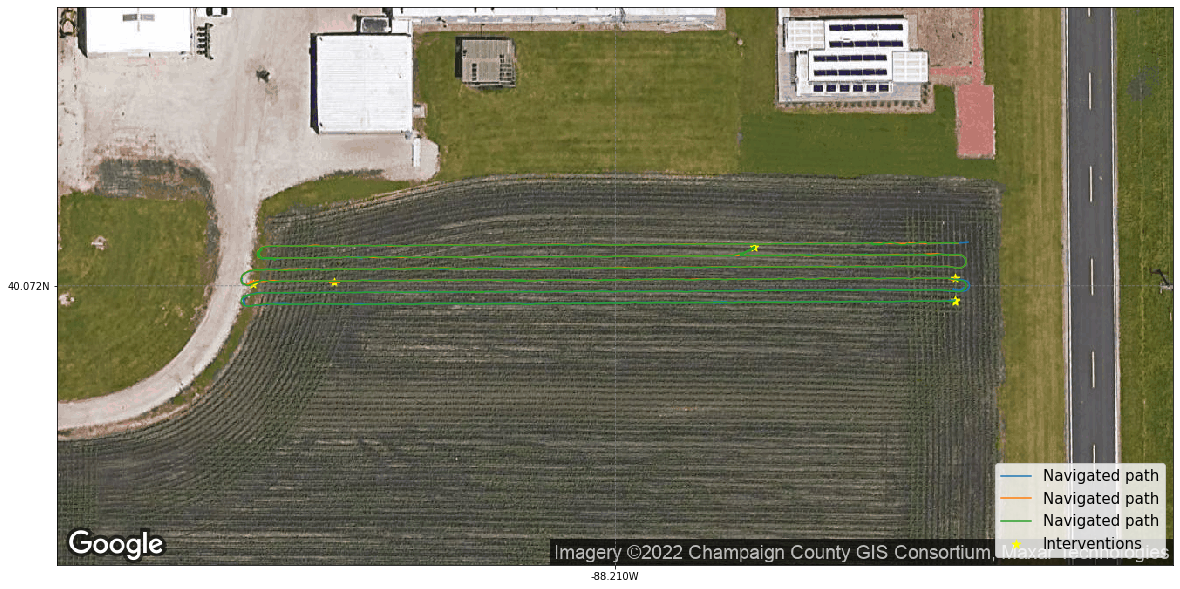

In [5]:
# Download map
g = GoogleVisibleMap(configs.map_lon, configs.map_lat, size_x=640, size_y=320, scale=2, maptype='satellite')  # try out also: 'terrain'

# Plot map
plt.figure(figsize=[20,12])

# the google static image is a standard rgb image
ggl_img = g.get_vardata()
# plt.imshow(ggl_img)

sm = Map(g.grid, factor=1, countries=False)
sm.set_rgb(ggl_img)
f, ax1 = plt.subplots(1, 1, figsize=(20, 12))
sm.visualize(ax = ax1)

print('len(collections_list):', len(collections_list))


interventions_lat = []
interventions_lon = []

# for bags_list in collections_list:
for bags_list in experiments:
    print('------------------------------')

    exp_lat_points = []
    exp_lon_points = []
    for rosbag_path in bags_list:
        path = os.path.join(configs.data_dir, rosbag_path)
        data_obj = DataExtractor(configs, path)
        bag_dict = data_obj.get_dict()
        # plot_map(configs, bag_dict)

        lat_points = [x[0] for x in bag_dict['gps']['lat_lon']]
        lon_points = [x[1] for x in bag_dict['gps']['lat_lon']]

        # Concat path points
        exp_lat_points.extend(lat_points)
        exp_lon_points.extend(lon_points)
        # Concat interventions
        interventions_lat.append(lat_points[-1])
        interventions_lon.append(lon_points[-1])

    # Plot path points
    x, y = sm.grid.transform(exp_lon_points, exp_lat_points)
    ax1.plot(x, y, label='Navigated path')

x, y = sm.grid.transform(interventions_lon, interventions_lat)
ax1.scatter(x, y, c='yellow', marker='*', s=80, label='Interventions')

lgnd = ax1.legend(loc="lower right",prop={'size': 15})

scalebar = AnchoredSizeBar(ax1.transData,
                           20, '20 m', 'lower center', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=1,)
                           #fontproperties=fontprops)

ax1.add_artist(scalebar)
# lgnd.legendHandles[0]._sizes = [60]
# ax1.set_xlabel('Longitude', fontsize = 14)
# ax1.set_ylabel('Latitude', fontsize = 14)
plt.show()